In [33]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [48]:
import numpy as np
import keras

In [52]:
x = np.random.rand(10, 128)
y = keras.layers.Conv1D(32, 10, activation='relu')(x)
print(y.shape)

ValueError: Input 0 of layer "conv1d_3" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (10, 128)

In [34]:
import tensorflow as tf

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [35]:
from keras.models import Sequential
from keras.layers import Dense

import plotly.express as px
import keras_tuner as kt
import pandas as pd
import keras

In [36]:
N_orders = 4
N_SKUIDs_predicted = 5

In [37]:
clients = pd.read_pickle("data/parsed/clients.pkl")
transactions = pd.read_pickle("data/parsed/modeling_transactions.pkl")

In [38]:
clients = (pd.concat([
            clients[["POC"]],
            pd.get_dummies(clients["BussinessSegment"], dtype=int),
        ],
        axis=1
    )
    .set_index(["POC"])
)

In [39]:
x_list = []
for i in range(N_orders):
    x = transactions.copy()
    x["ORDER_RANK"] += i
    x = x.set_index(["POC","ORDER_RANK"])
    x.columns = pd.Index(
        [str(c) + f"_x{i}" for c in x.columns],
        name = "SKU_ID"
    )

    x_list.append(x)


x = pd.concat(x_list, axis=1, ignore_index=False).dropna()
x = x.merge(clients, left_index=True, right_index=True, how="inner")


y = transactions.copy()
y["ORDER_RANK"] += -1
y = y.set_index(["POC","ORDER_RANK"])
y.columns = pd.Index(
    [str(c) + "_y" for c in y.columns],
    name="SKU_ID"
)


df = pd.concat([x,y], axis=1, ignore_index=False).dropna()
print(x.shape, y.shape, df.shape)

(31468, 608) (44032, 151) (27814, 759)


In [40]:
df_test = df.sample(frac=0.2)
df_train = df.merge(df_test[[]], left_index=True, right_index=True, indicator=True, how="left")
df_train = df_train[df_train["_merge"] == "left_only"].drop(columns="_merge").copy()


print(df_test.shape, df_train.shape)

(5563, 759) (22251, 759)


In [41]:
x_columns = [c for c in df_train.columns if "_y" not in c]
y_columns = [c for c in df_train.columns if "_y" in c]

x_test, y_test = df_test[x_columns].copy(), df_test[y_columns].copy()
x_train, y_train = df_train[x_columns].copy(), df_train[y_columns].copy()

y_test.columns = pd.Index(
    [c.replace("_y","") for c in y_columns],
    name="SKU_ID"
)

y_train.columns = pd.Index(
    [c.replace("_y","") for c in y_columns],
    name="SKU_ID"
)

print(x_test.shape, x_train.shape)
print(y_test.shape, y_train.shape)

(5563, 608) (22251, 608)
(5563, 151) (22251, 151)


In [42]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        #activation = hp.Choice("activation", ["sigmoid", "tanh"])
        activation = "tanh"
        model = Sequential([
                Dense(
                    y_train.shape[1],
                    activation = activation
                ),
                Dense(
                    y_train.shape[1],
                    activation = activation
                )
            ]
        )

        if hp.Boolean("3rd_layer"):
            model.add(
                Dense(
                    y_train.shape[1],
                    activation = activation
                )
            )

        model.compile(
            loss="mean_squared_error",
            metrics=[keras.metrics.MeanSquaredError()],
            optimizer=keras.optimizers.Adam(learning_rate=1e-4),
            # optimizer = keras.optimizers.Adam(
            #     hp.Choice(
            #         'learning_rate',
            #         values = [
            #             #1e-2,
            #             1e-3,
            #             1e-4,
            #             # 1e-5,
            #         ]
            #     )
            # )
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=16,
            # epochs = hp.Choice("epochs", [4, 8, 16]),
            batch_size=32,
            # batch_size = hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

tuner = kt.GridSearch(
    MyHyperModel(),
    overwrite=True,
    directory="models/dnn",
    project_name="dnn",
    objective=kt.Objective("val_mean_squared_error", direction="min"),
)

tuner.search(
    x_train.values,
    y_train.values,
    validation_data=(x_test, y_test)
)

tuner.results_summary()

best_model = tuner.get_best_models()[0]

Trial 2 Complete [00h 00m 12s]
val_mean_squared_error: 0.03053738921880722

Best val_mean_squared_error So Far: 0.03053738921880722
Total elapsed time: 00h 00m 22s
Results summary
Results in models/dnn/dnn
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 0001 summary
Hyperparameters:
3rd_layer: True
Score: 0.03053738921880722

Trial 0000 summary
Hyperparameters:
3rd_layer: False
Score: 0.030573347583413124


In [43]:
y_test_predicted = pd.DataFrame(
    best_model.predict(x_test.values),
    columns = y_test.columns,
    index=y_test.index
)

y_train_predicted = pd.DataFrame(
    best_model.predict(x_train.values),
    columns = y_train.columns,
    index=y_train.index
)


y_test_predicted = y_test_predicted.stack()
y_test_predicted.name = "predicted_value"
y_test_predicted = y_test_predicted.reset_index()
y_test_predicted = y_test_predicted.sort_values(["POC","ORDER_RANK","predicted_value"], ascending=False)
y_test_predicted["SKUID_PREDICTION_RANK"] = y_test_predicted.groupby(["POC","ORDER_RANK"])["predicted_value"].rank(method="first", ascending=False).astype(int)
y_test_predicted = y_test_predicted[y_test_predicted["SKUID_PREDICTION_RANK"] <= N_SKUIDs_predicted].copy()

y_train_predicted = y_train_predicted.stack()
y_train_predicted.name = "predicted_value"
y_train_predicted = y_train_predicted.reset_index()
y_train_predicted = y_train_predicted.sort_values(["POC","ORDER_RANK","predicted_value"], ascending=False)
y_train_predicted["SKUID_PREDICTION_RANK"] = y_train_predicted.groupby(["POC","ORDER_RANK"])["predicted_value"].rank(method="first", ascending=False).astype(int)
y_train_predicted = y_train_predicted[y_train_predicted["SKUID_PREDICTION_RANK"] <= N_SKUIDs_predicted].copy()

696/696 [==============================] - 0s 320us/step


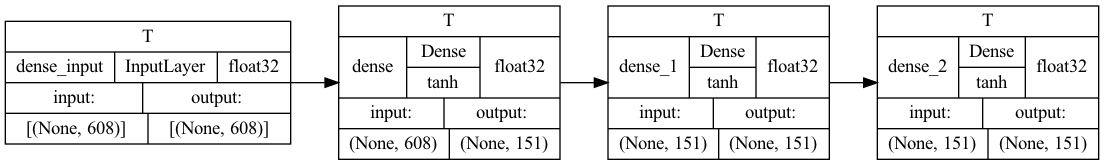

In [53]:
keras.utils.plot_model(
    best_model,
    show_dtype=True,
    show_layer_names=True,
    show_shapes=True,
    rankdir="LR",
    show_layer_activations=True,
    show_trainable=True,
)

In [45]:
px.histogram(y_test_predicted, x="predicted_value", color="SKUID_PREDICTION_RANK", barmode="overlay", histnorm="probability", title="test").show()
px.histogram(y_train_predicted, x="predicted_value", color="SKUID_PREDICTION_RANK", barmode="overlay", histnorm="probability", title="train").show()

In [46]:
y_test = y_test.stack()
y_test = y_test[y_test == 1].copy()
y_test.name = "present_values"
y_test = y_test.reset_index()

y_train = y_train.stack()
y_train = y_train[y_train == 1].copy()
y_train.name = "present_values"
y_train = y_train.reset_index()

Both is good, left_only is bad

In [47]:
N_ROUNDING = 2

test_accuracy = (y_test_predicted
    .merge(y_test,
        on=["POC","ORDER_RANK","SKU_ID"],
        how="left",
        indicator=True
    )
)

train_accuracy = (y_train_predicted
    .merge(y_train,
        on=["POC","ORDER_RANK","SKU_ID"],
        how="left",
        indicator=True
    )
)

test_accuracy["accurate"] = test_accuracy["_merge"] == "both"
train_accuracy["accurate"] = train_accuracy["_merge"] == "both"

counts = test_accuracy[["SKUID_PREDICTION_RANK","accurate"]].value_counts().rename("counts").reset_index()
total_counts = test_accuracy[["SKUID_PREDICTION_RANK"]].value_counts().rename("total_counts").reset_index()
test_accuracy_byPredictionRank = counts.merge(total_counts, on=["SKUID_PREDICTION_RANK"], how="left")
test_accuracy_byPredictionRank["accuracy"] = (test_accuracy_byPredictionRank["counts"] / test_accuracy_byPredictionRank["total_counts"]).round(N_ROUNDING)
test_accuracy_byPredictionRank = test_accuracy_byPredictionRank.set_index(["SKUID_PREDICTION_RANK","accurate"]).sort_index()
test_accuracy_byPredictionRank.columns.name = "test"

counts = train_accuracy[["SKUID_PREDICTION_RANK","accurate"]].value_counts().rename("counts").reset_index()
total_counts = train_accuracy[["SKUID_PREDICTION_RANK"]].value_counts().rename("total_counts").reset_index()
train_accuracy_byPredictionRank = counts.merge(total_counts, on=["SKUID_PREDICTION_RANK"], how="left")
train_accuracy_byPredictionRank["accuracy"] = (train_accuracy_byPredictionRank["counts"] / train_accuracy_byPredictionRank["total_counts"]).round(N_ROUNDING)
train_accuracy_byPredictionRank = train_accuracy_byPredictionRank.set_index(["SKUID_PREDICTION_RANK","accurate"]).sort_index()
train_accuracy_byPredictionRank.columns.name = "train"

display(test_accuracy_byPredictionRank)
display(train_accuracy_byPredictionRank)


test_accuracy_agg = test_accuracy[["accurate"]].value_counts().rename("counts").reset_index()
test_accuracy_agg["total_counts"] = len(test_accuracy)
test_accuracy_agg["accuracy"] = (test_accuracy_agg["counts"] / test_accuracy_agg["total_counts"]).round(N_ROUNDING)
test_accuracy_agg = test_accuracy_agg.set_index(["accurate"]).sort_index()
test_accuracy_agg.columns.name = "test"

train_accuracy_agg = train_accuracy[["accurate"]].value_counts().rename("counts").reset_index()
train_accuracy_agg["total_counts"] = len(train_accuracy)
train_accuracy_agg["accuracy"] = (train_accuracy_agg["counts"] / train_accuracy_agg["total_counts"]).round(N_ROUNDING)
train_accuracy_agg = train_accuracy_agg.set_index(["accurate"]).sort_index()
train_accuracy_agg.columns.name = "train"

display(test_accuracy_agg)
display(train_accuracy_agg)

test                            counts  total_counts  accuracy
SKUID_PREDICTION_RANK accurate                                
1                     False       2521          5563      0.45
                      True        3042          5563      0.55
2                     False       3286          5563      0.59
                      True        2277          5563      0.41
3                     False       3670          5563      0.66
                      True        1893          5563      0.34
4                     False       4000          5563      0.72
                      True        1563          5563      0.28
5                     False       4222          5563      0.76
                      True        1341          5563      0.24

train                           counts  total_counts  accuracy
SKUID_PREDICTION_RANK accurate                                
1                     False       9491         22251      0.43
                      True       12760         22251      0.57
2                     False      12465         22251      0.56
                      True        9786         22251      0.44
3                     False      14192         22251      0.64
                      True        8059         22251      0.36
4                     False      15277         22251      0.69
                      True        6974         22251      0.31
5                     False      16136         22251      0.73
                      True        6115         22251      0.27

test      counts  total_counts  accuracy
accurate                                
False      17699         27815      0.64
True       10116         27815      0.36

train     counts  total_counts  accuracy
accurate                                
False      67561        111255      0.61
True       43694        111255      0.39